# Принятие решений в бизнесе

**Цель проекта** - используя данные интернет-магазина произвести оценку результатов A/B-теста.

*В качестве входных данных используются датасеты содержащие:*

- Заказы; 
- Количество пользователей в указанную дату в указанной группе A/B-теста.

**Ход исследования:**

1. Обзор данных;
2. Предобработка данных;
3. Анализ A/B-теста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
sns.set(rc={'figure.figsize':(12, 6), 'figure.dpi': 200})
sns.set_theme(style='whitegrid')
pd.set_option("display.precision", 2)

In [3]:
orders   = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

## Обзор данных

### В таблице orders

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


**Согласно документации к данным:**

`transactionId` — идентификатор заказа;  
`visitorId` — идентификатор пользователя, совершившего заказ;  
`date` — дата, когда был совершён заказ; 
`revenue` — выручка заказа;  
`group` — группа A/B-теста, в которую попал заказ.

In [5]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
237,2305128914,4134011281,2019-08-23,6149,A
264,3795138501,887812064,2019-08-18,170,A
217,2503419221,3429232516,2019-08-02,1680,B
54,4159234359,3660046170,2019-08-16,100,A
19,674584210,3207734412,2019-08-15,1190,A


### В таблице visitors

In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Согласно документации к данным:**

`date` — дата;  
`group` — группа A/B-теста;  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [7]:
visitors.sample(5)

,date,group,visitors
3,2019-08-04,A,717
45,2019-08-15,B,544
0,2019-08-01,A,719
9,2019-08-10,A,406
56,2019-08-26,B,676


### Вывод

- В датасетах нет пропусков;
- Дата представлена в неправильном формате;
- В таблице orders названия столбцов в camelCase.

## Предобработка данных

**Что бы предобработать данные, выполним следующие действия:**

- Уберем camelCase;
- Приведем дату к формату даты;
- Проверим на дубликаты.

### Преобразование camelCase 

In [8]:
orders.columns = orders.columns.str.replace(r'[A-Z]', lambda m: '_' + m.group(0).lower(), regex=True)

### Приведение к формату даты

In [9]:
orders['date'] = pd.to_datetime(orders['date'])

In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

### Обработка дубликатов

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.duplicated().sum()

0

### Вывод

- Преобразован camelCase;
- Даты приведены к формату даты;
- Дубликатов в датасетах не было.

## Анализ A/B-теста

**Для анализа A/B-теста нам понадобится:**

- Построить график кумулятивной выручки по группам;
- Построить график кумулятивного среднего чека по группам;
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A;
- Построить график кумулятивной конверсии по группам;
- Построить график относительного изменения кумулятивной конверсии группы B к группе A;
- Построить точечный график количества заказов по пользователям;
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей;
- Построить точечный график стоимостей заказов;
- Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов;
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным;
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным;
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

*Проверим качество разделения на группы*

In [13]:
wrong_users = (orders.groupby('visitor_id')
               .agg({'group' : 'nunique'})
               .query('group > 1')
               .reset_index())['visitor_id']
wrong_users = orders[orders['visitor_id'].isin(wrong_users)]

In [14]:
wrong_users['visitor_id'].nunique()

58

***Пользователи разделены на группы не точно, есть те кто состоит в обеих группах, такое возможно могло произойти при не совсем верном делении при проведении А/А теста. Удалим этих пользователей из таблицы orders и visitors.***

In [15]:
wrong_visitors = wrong_users.groupby(['date', 'group'])['transaction_id'].count().reset_index()

In [16]:
visitors = visitors.merge(wrong_visitors, how='left', on=['date', 'group']).fillna(0)

In [17]:
visitors['visitors'] = visitors['visitors'] - visitors['transaction_id']

In [18]:
visitors['visitors'] = visitors['visitors'].astype('int')

In [19]:
visitors = visitors.drop(columns='transaction_id')

In [20]:
orders = orders[~orders['transaction_id'].isin(wrong_users['transaction_id'])]

### График кумулятивной выручки по группам

In [21]:
# массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

In [22]:
# агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = (dates_groups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                     .agg({'date' : 'max', 
                           'group' : 'max', 
                           'transaction_id' : 'nunique', 
                           'visitor_id' : 'nunique', 
                           'revenue' : 'sum'}
                         ), axis=1)
                     .sort_values(by=['date','group'])
                    )

In [23]:
# получаем агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = (dates_groups
                       .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                       .agg({'date' : 'max', 
                             'group' : 'max', 
                             'visitors' : 'sum'}
                           ), axis=1)
                       .sort_values(by=['date','group'])
                      )

In [24]:
# кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [25]:
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,718
1,2019-08-01,B,17,17,59758,709
2,2019-08-02,A,42,36,234381,1336
3,2019-08-02,B,40,39,221801,1289
4,2019-08-03,A,66,60,346854,1843
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17622
58,2019-08-30,A,460,437,3311413,17952
59,2019-08-30,B,531,511,4955833,18109
60,2019-08-31,A,468,445,3364656,18647


In [26]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

In [27]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

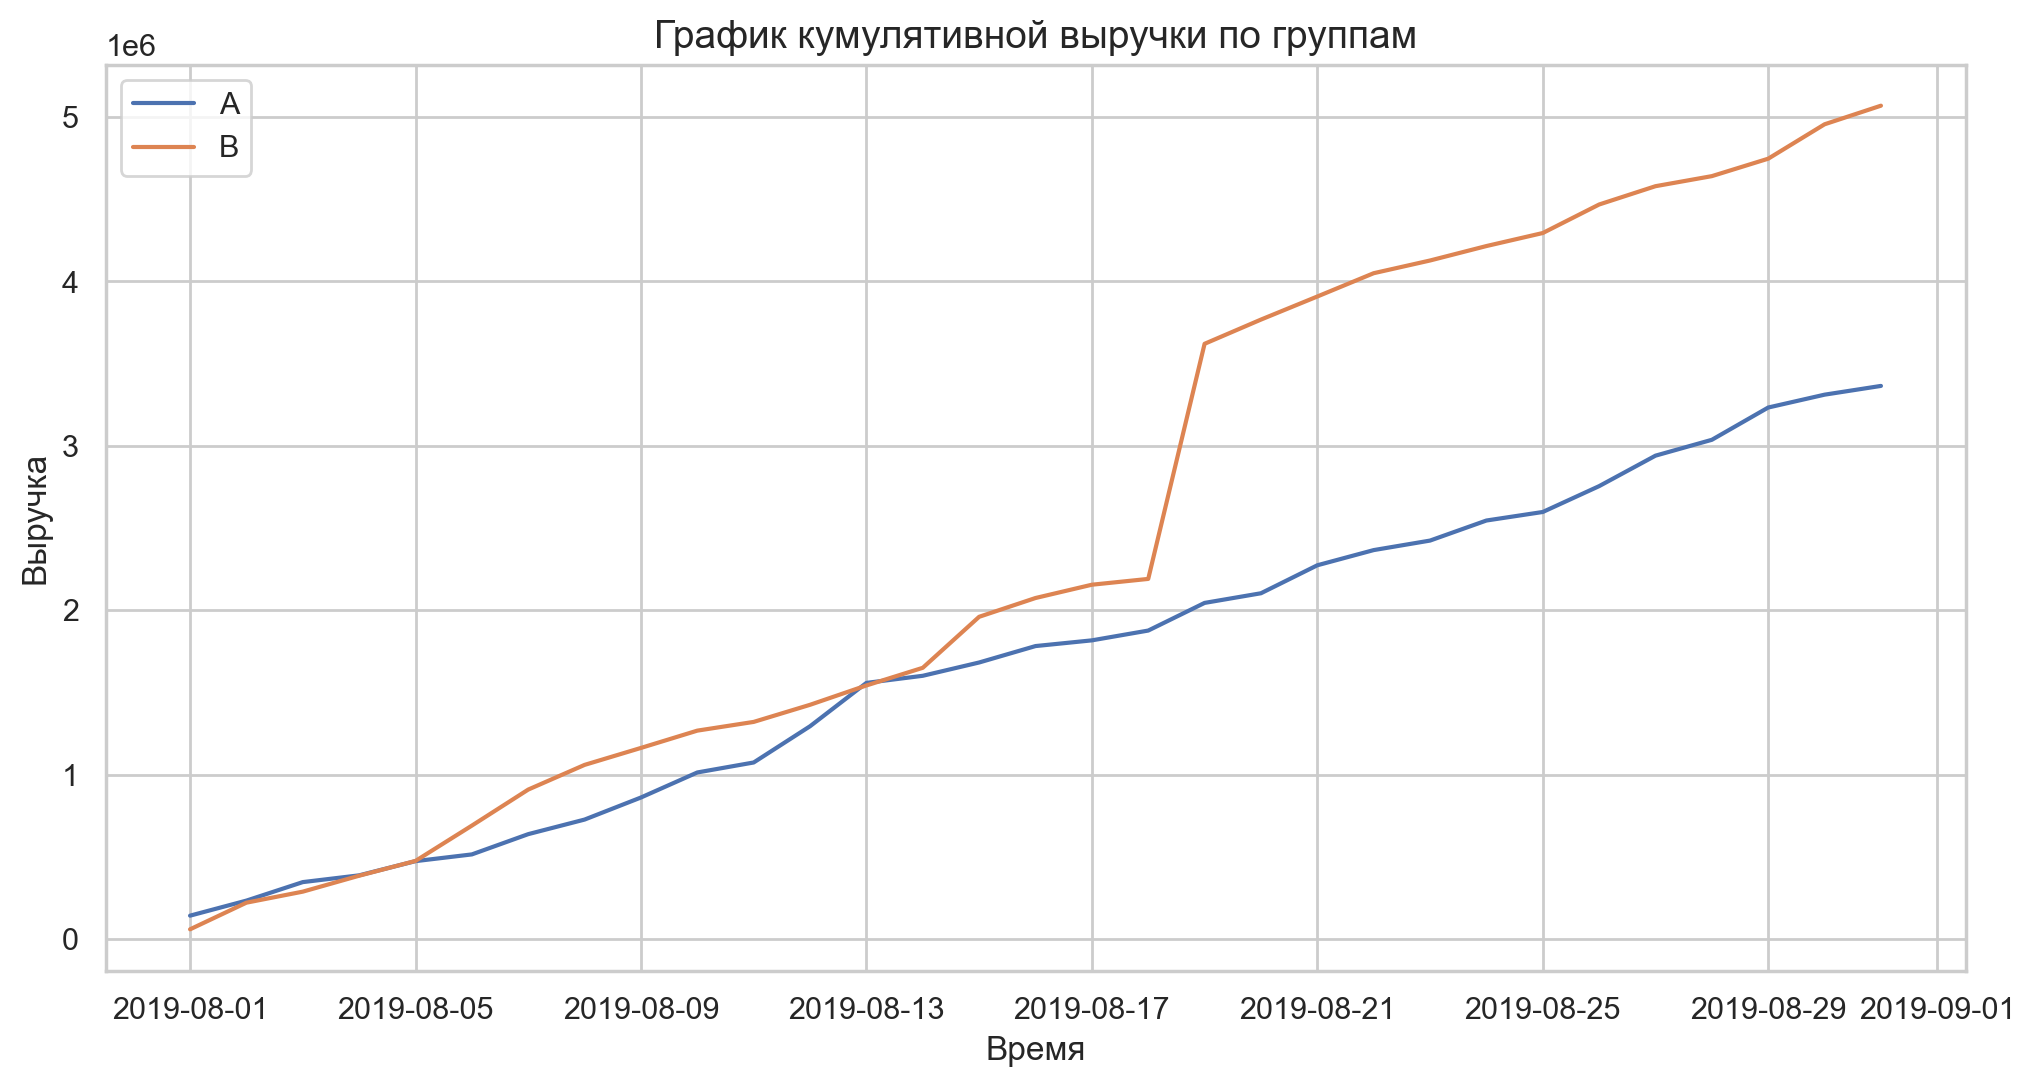

In [28]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.title('График кумулятивной выручки по группам', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Выручка')
plt.legend();

#### Вывод 

- Выручка увеличивается;
- Имеется резкий скачок выручки в группе В, либо из-за увеличившихся числа заказов, либо из-за появившихся очень дорогих заказов.

### График кумулятивного среднего чека по группам

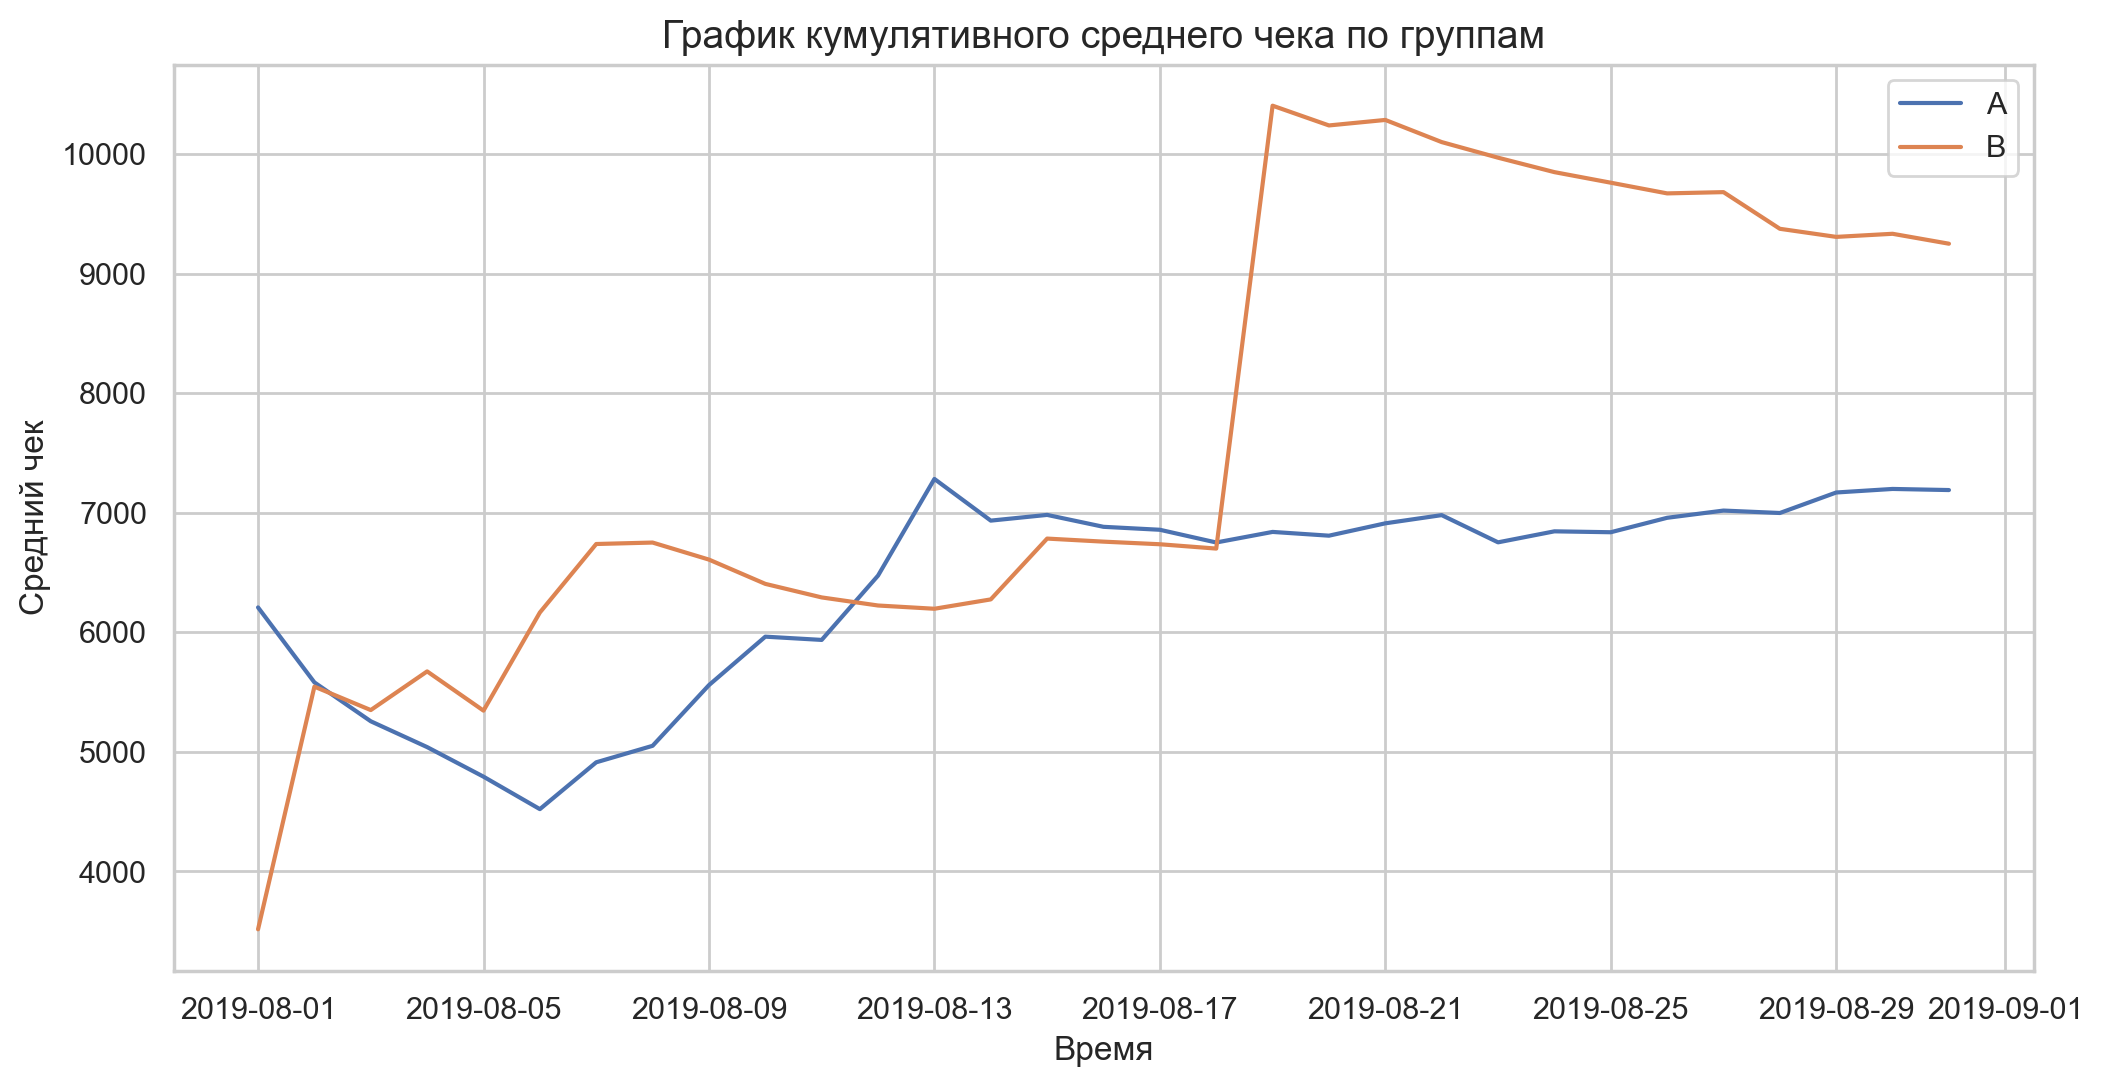

In [29]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Средний чек')
plt.legend();

#### Вывод

- Средний чек становится равномерным у группы А после 13 августа;
- Средний чек группы В растет с самого начала и 18 августа происходит резкий скачок на 40%, после падает.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [30]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, 
                                                       left_on='date', 
                                                       right_on='date', 
                                                       how='left', 
                                                       suffixes=['A', 'B']
                                                      )

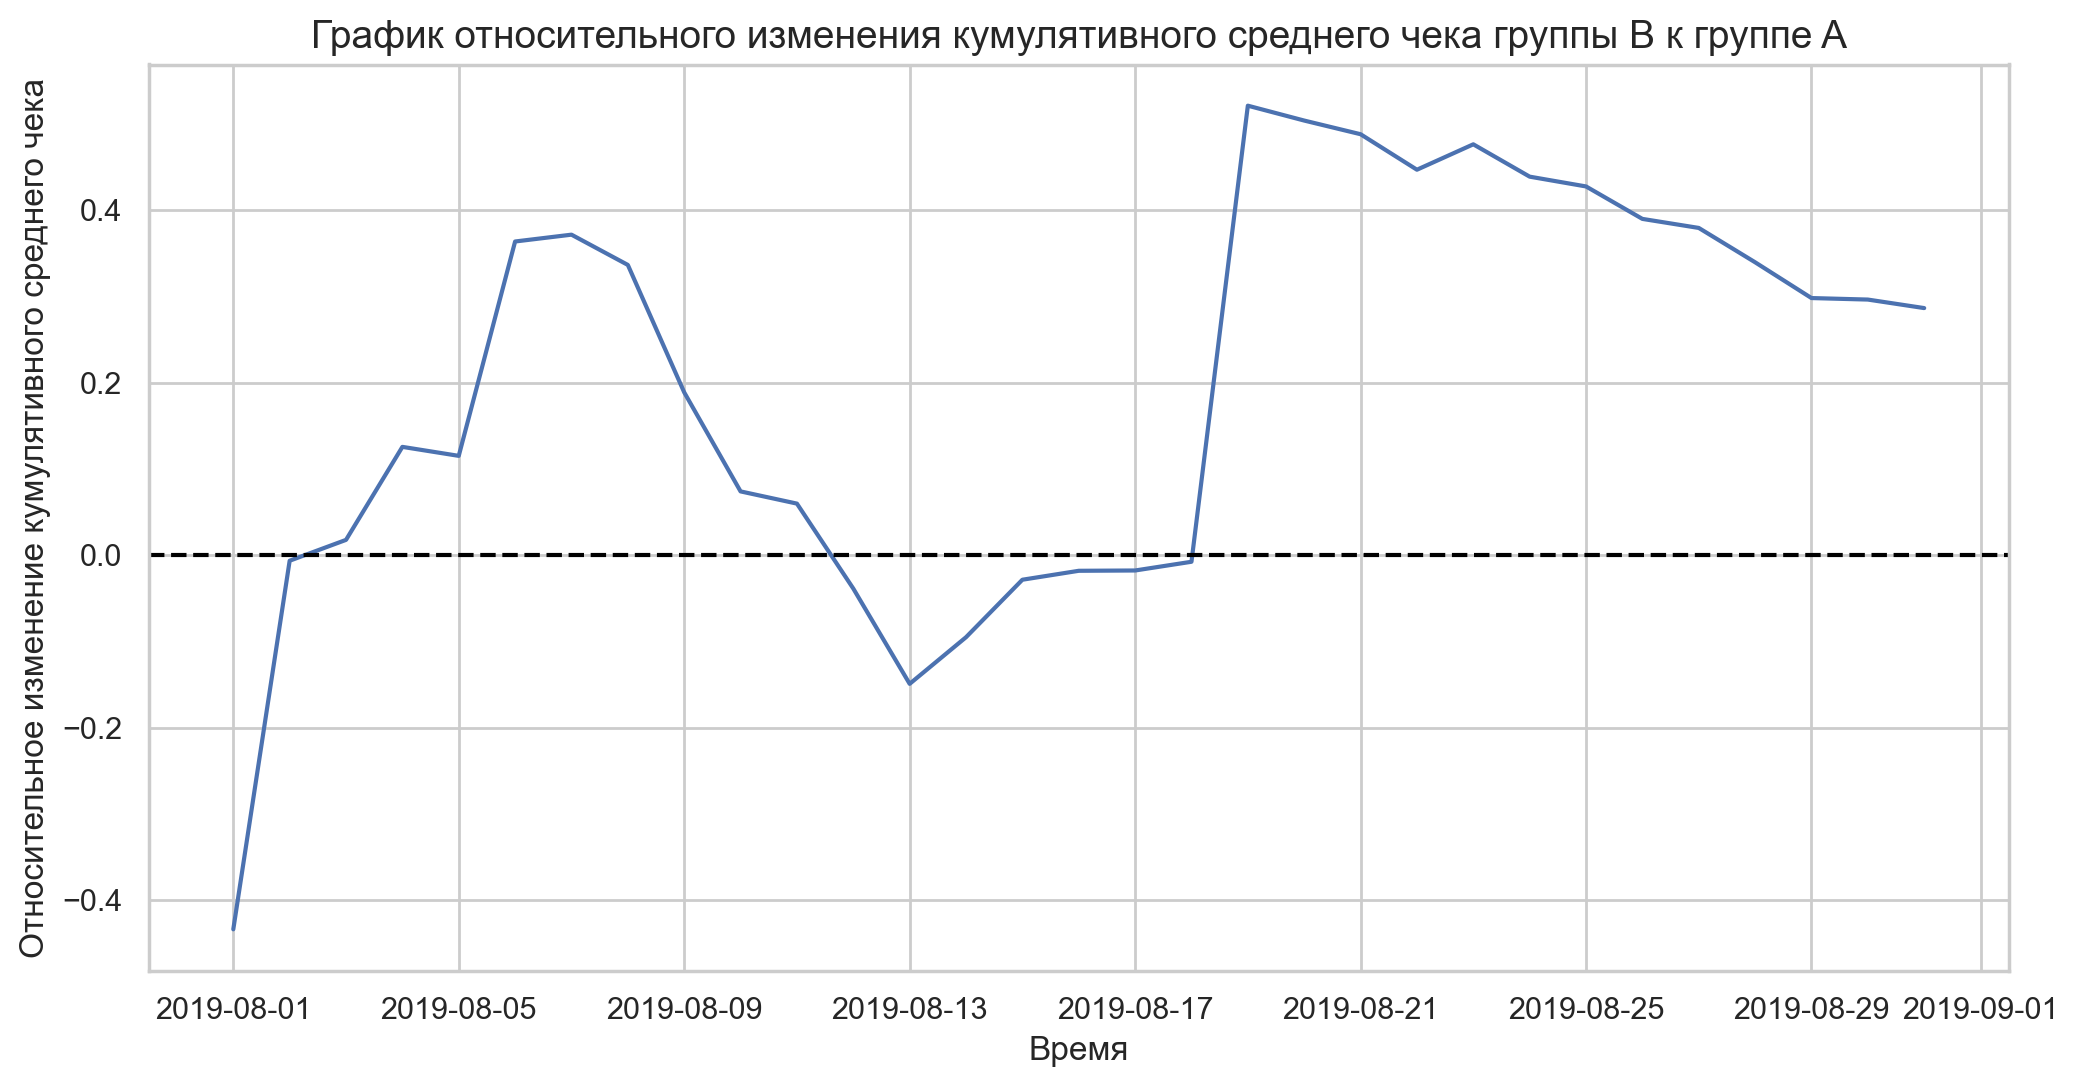

In [31]:
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1
        )

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Относительное изменение кумулятивного среднего чека');

#### Вывод

- График очень ломанный;
- Попеременно лидирует то одна группа, то другая;
- Есть вероятность что в группе В имеются выбросы.

### График кумулятивной конверсии по группам

In [32]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

In [33]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

In [34]:
# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

In [35]:
min_date = cumulative_data['date'].min()

In [36]:
max_date = cumulative_data['date'].max()

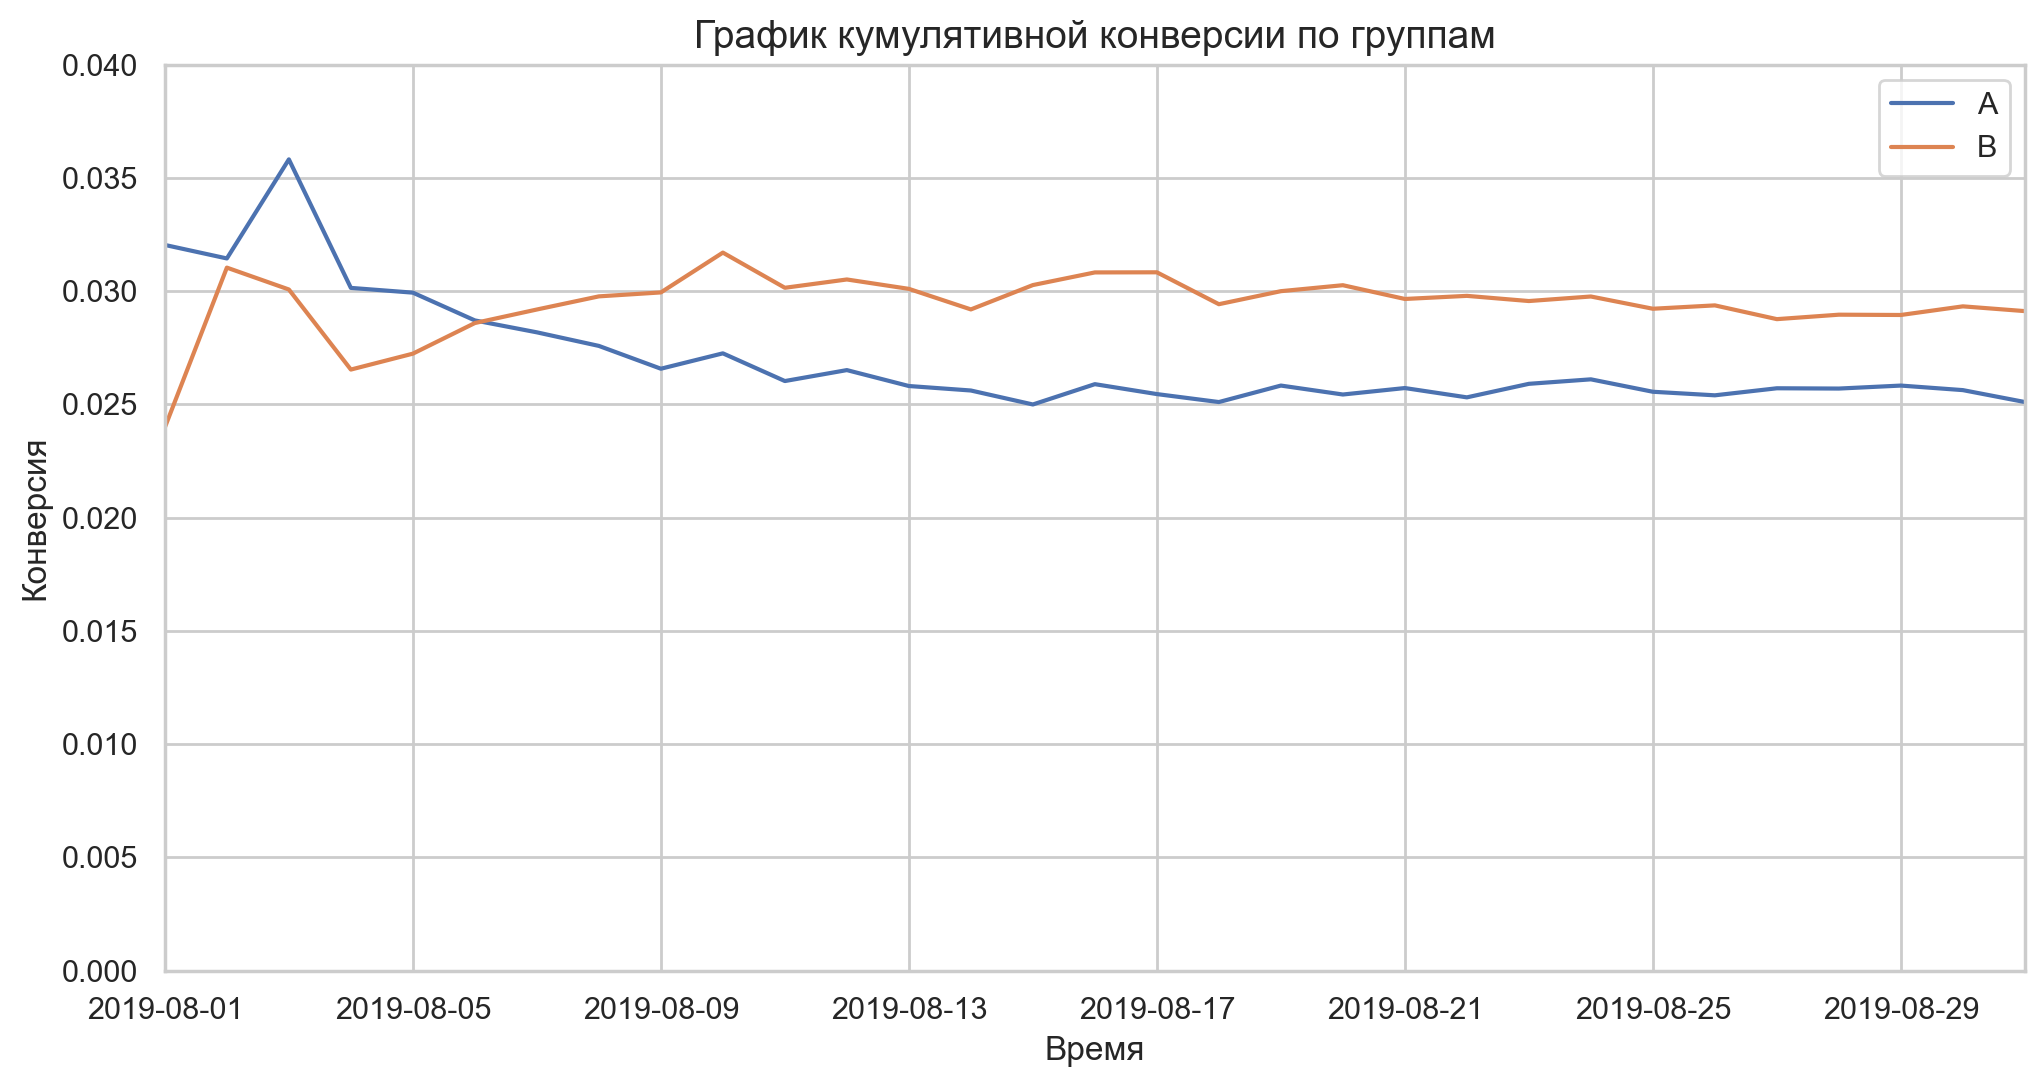

In [37]:
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Конверсия')
plt.legend()
plt.axis([min_date, max_date, 0, 0.04]);

#### Вывод

- Конверсия группы А сначала показывала рост, но потом просела и стабилизировалась на уровне 0.25%;
- Конверсия группы В на 6 день опередила группу А и стабильно показывает лучший результат на уровне 3%.

### График относительного изменения кумулятивной конверсии группы B к группе A

In [38]:
merged_сumulative_сonversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], 
                                                                               left_on='date', 
                                                                               right_on='date', 
                                                                               how='left', 
                                                                               suffixes=['A', 'B']
                                                                              )

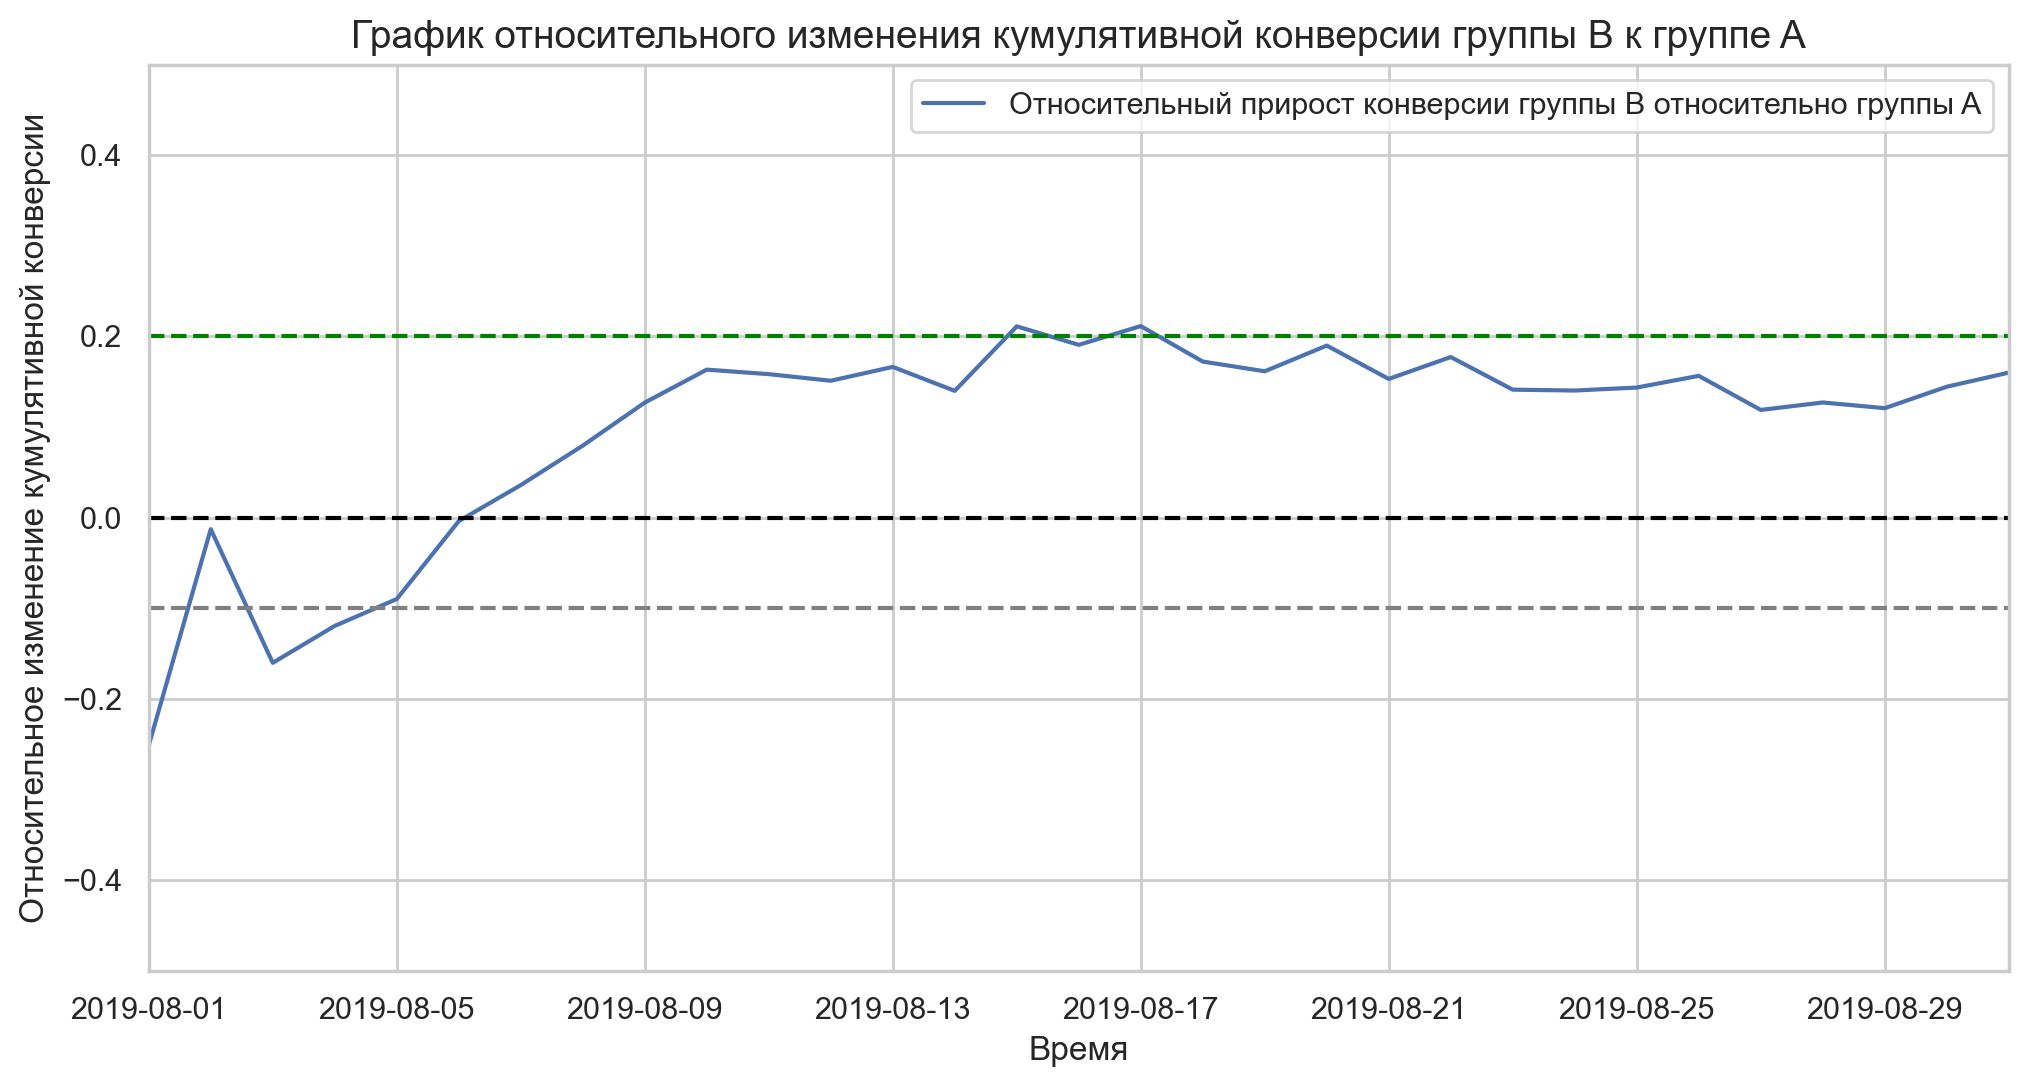

In [39]:
plt.plot(merged_сumulative_сonversions['date'], 
         merged_сumulative_сonversions['conversionB']/merged_сumulative_сonversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A"
        )
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axhline(y=0.2, color='green', linestyle='--')
plt.axis([min_date, max_date, -0.5, 0.5]);

#### Вывод

- Первые 6 дней конверсия группы В была хуже конверсии группы А;
- После конверсия группы В увеличилась на 20% и стабилизировалась.

### Точечный график количества заказов по пользователям

In [40]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})

In [41]:
orders_by_users.columns = ['user_id', 'orders']

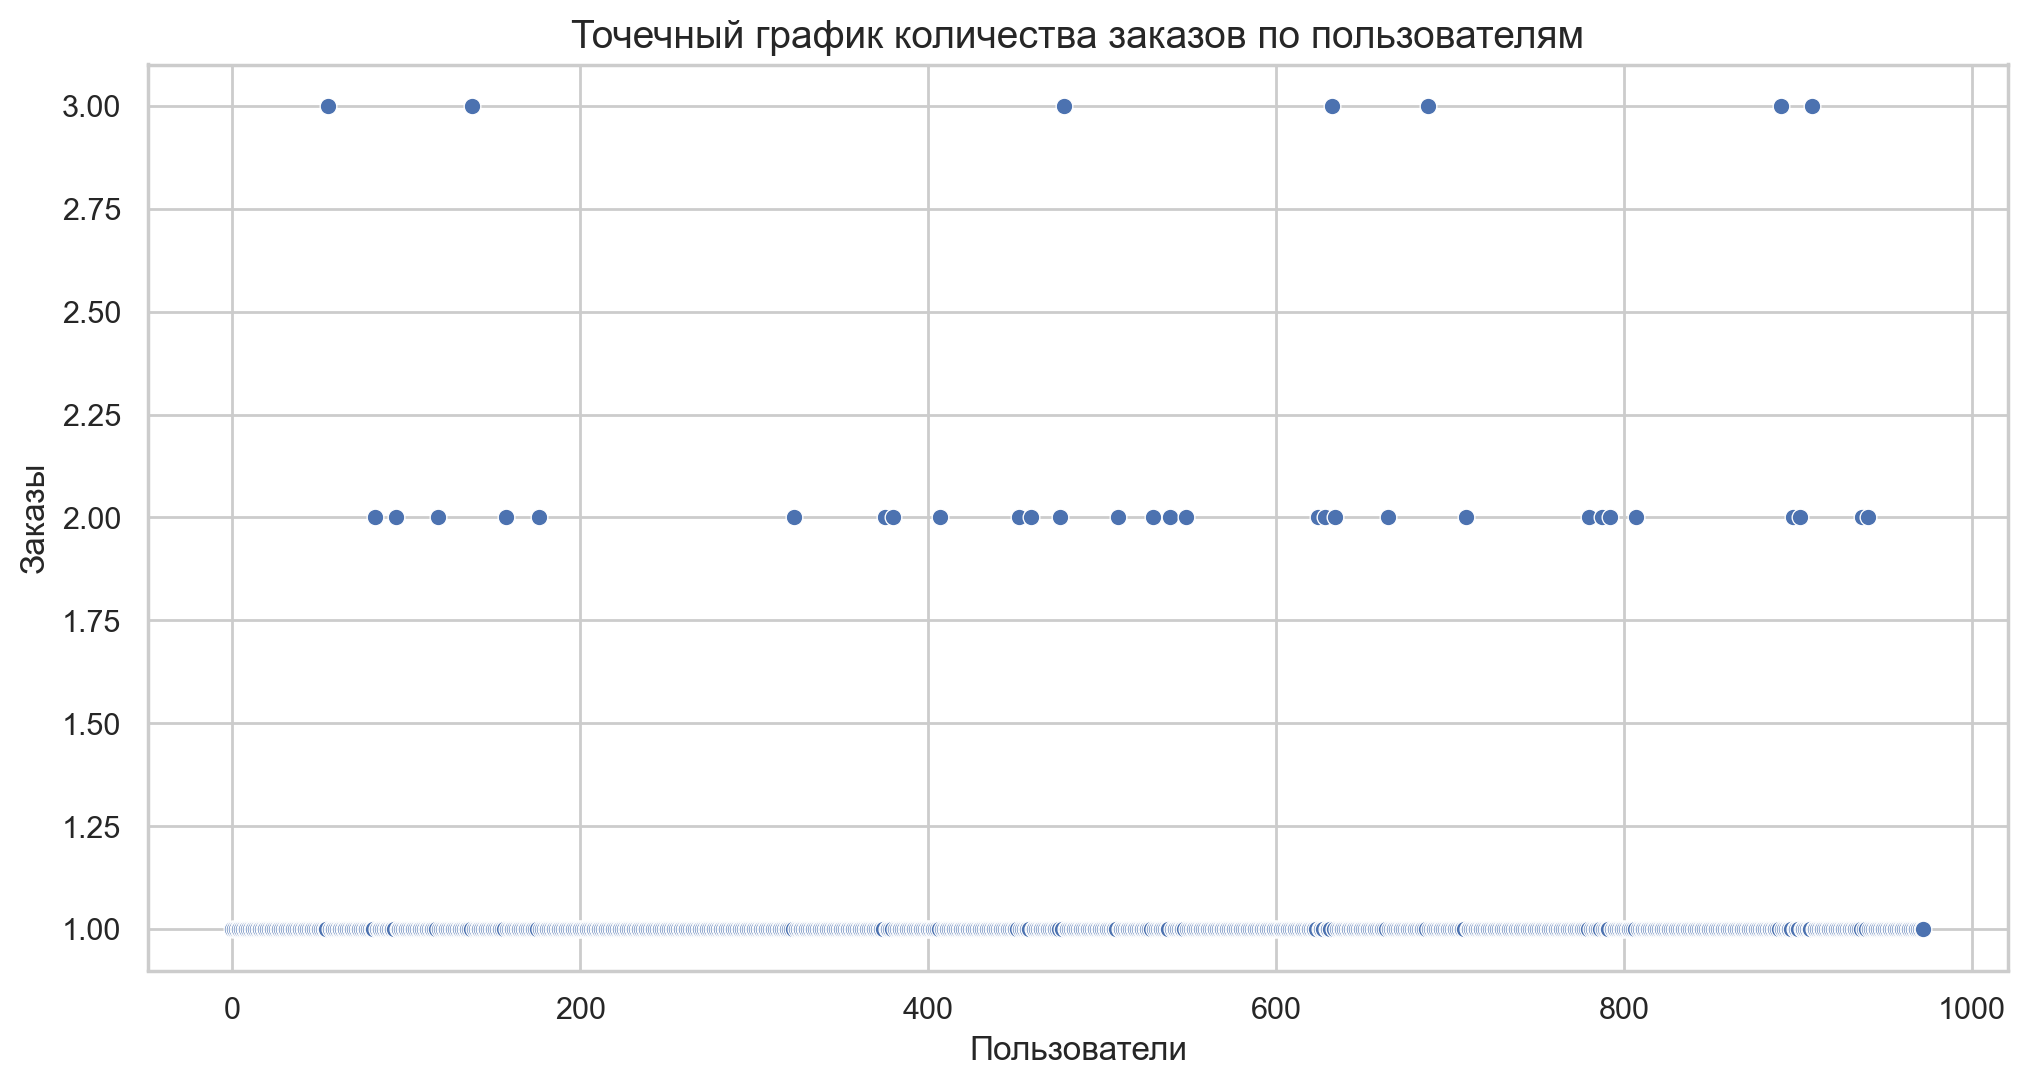

In [42]:
sns.scatterplot(data=orders_by_users, x=pd.Series(range(0,len(orders_by_users))), y='orders')
plt.title('Точечный график количества заказов по пользователям', fontsize=14)
plt.xlabel('Пользователи')
plt.ylabel('Заказы');

In [43]:
np.percentile(orders_by_users['orders'], [90, 95, 99])

array([1., 1., 2.])

In [44]:
orders_percentile_99 = np.percentile(orders_by_users['orders'], 99)

#### Вывод

- Большинство пользователей покупали только один раз;
- Много пользователей покупали и по 2 раза;
- Данный факт подтверждает 99 перцентиль, его и выберем за нижнюю границу количества аномальных заказов.

### Точечный график стоимостей заказов

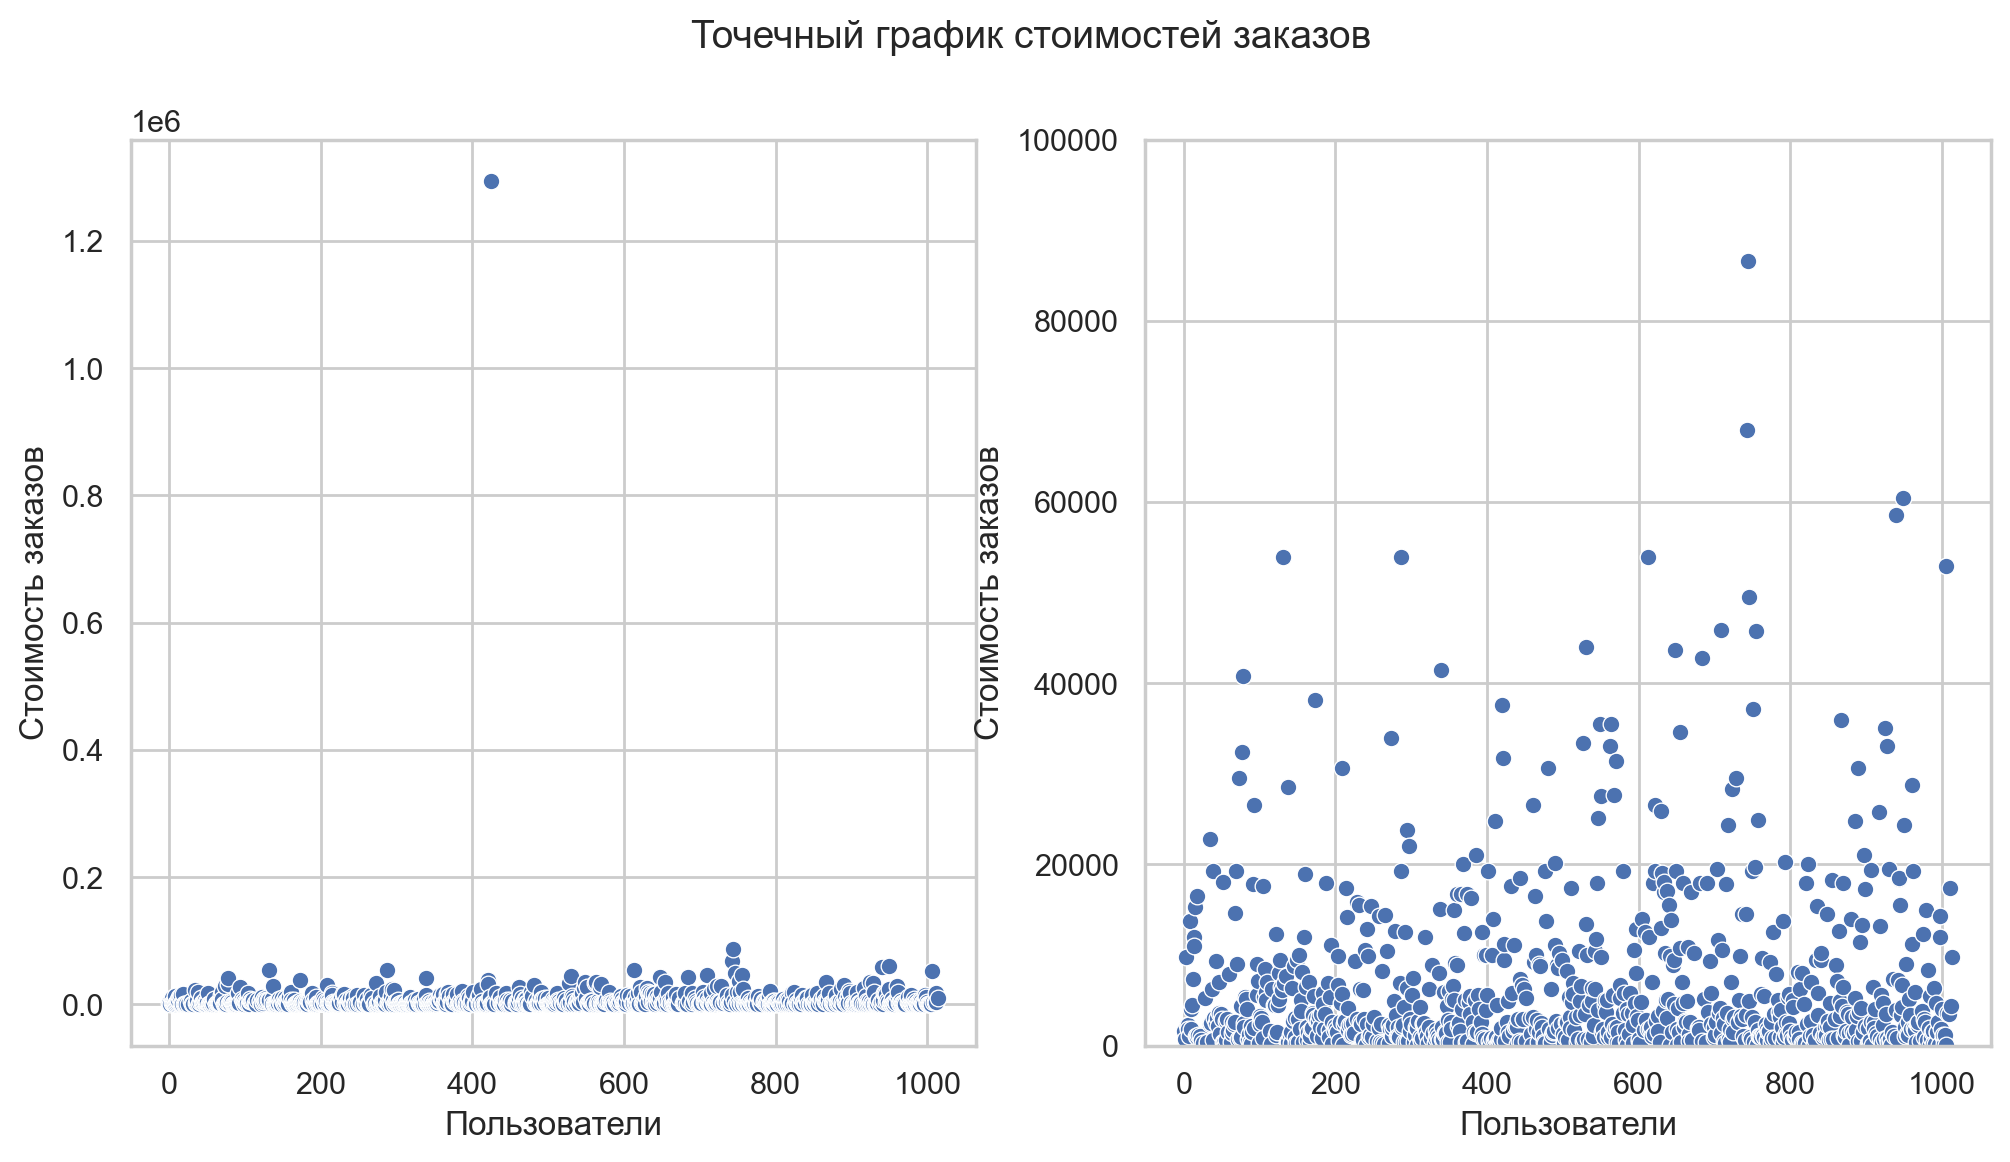

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plt.suptitle('Точечный график стоимостей заказов', fontsize=14)

sns.scatterplot(data=orders, x=pd.Series(range(0,len(orders))), y='revenue', ax=ax1)
ax1.set_xlabel('Пользователи')
ax1.set_ylabel('Стоимость заказов')

sns.scatterplot(data=orders, x=pd.Series(range(0,len(orders))), y='revenue', ax=ax2)
ax2.set_ylim(0, 100000)
ax2.set_xlabel('Пользователи')
ax2.set_ylabel('Стоимость заказов');

In [46]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

In [47]:
revenue_percentile_95 = np.percentile(orders['revenue'], 95)

#### Вывод

- Основная масса заказов сосредоточена до 20000 у.е. 
- Есть и крупные заказы от 60000 у.е.
- Имеется супер аномальный заказ на 1.3 млн.
- Прослеживается граница стоимостей аномальных заказов между 20000 и 40000 у.е.
- За нижнюю границу стоимостей аномальных заказов возьмем 95 перцентиль, который равен 26785 у.е.

### Различие в конверсии между группами по «сырым» данным

In [48]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

In [49]:
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

In [50]:
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [51]:
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

In [52]:
visitors_A_cummulative = visitors_A_daily.apply(
                        lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
                        {'date': 'max', 'visitors_per_date_A': 'sum'}
                        ),
                        axis=1,
                        )

In [53]:
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

In [54]:
visitors_B_cummulative = visitors_B_daily.apply(
                        lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
                        {'date': 'max', 'visitors_per_date_B': 'sum'}
                        ),
                        axis=1,
                        )

In [55]:
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

In [56]:
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

In [57]:
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

In [58]:
orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [59]:
orders_A_cummulative.columns = ['date', 'orders_cummulative_A', 'revenue_cummulative_A']

In [60]:
orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)

In [61]:
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

In [62]:
orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [63]:
orders_B_cummulative.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

In [64]:
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

In [65]:
data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,718,709,718,709
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,618,580,1336,1289
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,507,1843,1796
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,712,767,2555,2563
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,753,705,3308,3268


In [66]:
orders_by_users_A = (orders[orders['group'] == 'A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id': pd.Series.nunique})
                 )

In [67]:
orders_by_users_A.columns = ['user_id', 'orders']

In [68]:
orders_by_users_B = (orders[orders['group'] == 'B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id': pd.Series.nunique})
                 )

In [69]:
orders_by_users_B.columns = ['user_id', 'orders']

In [70]:
sample_A = pd.concat([orders_by_users_A['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],
                      axis=0
                    )

In [71]:
sample_B = pd.concat([orders_by_users_B['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],
                      axis=0
                    )

**Сформулируем нулевую гипотезу:** различий в конверсии между группами нет.  
**Сформулируем алтернативную гипотезу:** различия в конверсии между группами есть.

In [72]:
alpha = 0.05

In [73]:
results = st.mannwhitneyu(sample_A, sample_B)
print('p-значение:', results[1])

if results[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print(f'Разница в конверсии: {(sample_B.mean() / sample_A.mean() - 1):.3f}')

p-значение: 0.0109567830835148
Отвергаем нулевую гипотезу
Разница в конверсии: 0.160


#### Вывод

**По результатам теста конверсии «сырых» данных было выяснено, что:**

- Различие между группами в конверсии есть;
- Выигрыш в конверсии составил 16 % в пользу группы В.

### Различия в среднем чеке заказа между группами по «сырым» данным

**Сформулируем нулевую гипотезу:** различий в среднем чеке между группами нет.  
**Сформулируем алтернативную гипотезу:** различия в среднем чеке между группами есть.

In [74]:
revenue_A = orders[orders['group']=='A']['revenue']

In [75]:
revenue_B = orders[orders['group']=='B']['revenue']

In [76]:
results = st.mannwhitneyu(revenue_A, revenue_B)
print('p-значение:', results[1])

if results[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print(f'Разница в среднем чеке: {(revenue_B.mean() / revenue_A.mean() - 1):.3f}')

p-значение: 0.8294908998149533
Не получилось отвергнуть нулевую гипотезу
Разница в среднем чеке: 0.287


#### Вывод

**По результатам теста среднего чека «сырых» данных было выяснено, что:**

- Различие между группами в среднем чеке нет;
- Хотя, выигрыш в среднем чеке составил 28.7 % в пользу группы В.
- Скорее всего имеют место быть аномалии стоимостей заказов в группе В.

### Различие в конверсии между группами по «очищенным» данным

In [77]:
print(f'Примем за аномальных пользователей тех кто совершил больше {orders_percentile_99:.0f} заказов'
      f' или совершил заказ дороже {revenue_percentile_95:.0f} у.е.')

Примем за аномальных пользователей тех кто совершил больше 2 заказов или совершил заказ дороже 26785 у.е.


In [78]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > orders_percentile_99]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > orders_percentile_99]['user_id'],
    ],
    axis=0,
)

In [79]:
users_with_expensive_orders = orders[orders['revenue'] > revenue_percentile_95]['visitor_id']

In [80]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [81]:
print(abnormal_users.head(5))
print(abnormal_users.shape) 
print(abnormal_users.shape[0] / orders_by_users.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
(58,)
0.05960945529290853


***58 аномальных пользователей, которые составляют 6% от общего числа.*** 

In [82]:
sample_A_filtered = pd.concat([orders_by_users_A[~orders_by_users_A['user_id'].isin(abnormal_users)]['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],
                      axis=0
                    )

In [83]:
sample_B_filtered = pd.concat([orders_by_users_B[~orders_by_users_B['user_id'].isin(abnormal_users)]['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],
                      axis=0
                    )

**Сформулируем нулевую гипотезу:** различий в конверсии между группами нет.  
**Сформулируем алтернативную гипотезу:** различия в конверсии между группами есть.

In [84]:
results = st.mannwhitneyu(sample_A_filtered, sample_B_filtered)
print('p-значение:', results[1])

if results[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print(f'Разница в конверсии: {(sample_B_filtered.mean() / sample_A_filtered.mean() - 1):.3f}')

p-значение: 0.012285273602771688
Отвергаем нулевую гипотезу
Разница в конверсии: 0.182


#### Вывод

**По результатам теста конверсии «очищенных» данных было выяснено, что:**

- Различие между группами в конверсии есть;
- Аномальные пользователи оказывали влияние на конверсию;
- Выигрыш в конверсии увеличился и составил 18.2 % в пользу группы В.

### Различия в среднем чеке заказа между группами по «очищенным» данным

**Сформулируем нулевую гипотезу:** различий в среднем чеке между группами нет.  
**Сформулируем алтернативную гипотезу:** различия в среднем чеке между группами есть.

In [85]:
revenue_A_filtered = orders[(orders['group']=='A') & ~(orders['visitor_id'].isin(abnormal_users))]['revenue']

In [86]:
revenue_B_filtered = orders[(orders['group']=='B') & ~(orders['visitor_id'].isin(abnormal_users))]['revenue']

In [87]:
results = st.mannwhitneyu(revenue_A_filtered, revenue_B_filtered)
print('p-значение:', results[1])

if results[1] < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
print(f'Разница в среднем чеке: {(revenue_B_filtered.mean() / revenue_A_filtered.mean() - 1):.3f}')

p-значение: 0.6458964038091206
Не получилось отвергнуть нулевую гипотезу
Разница в среднем чеке: -0.048


#### Вывод

**По результатам теста среднего чека «очищенных» данных было выяснено, что:**

- Различие между группами в среднем чеке нет;
- Разница в среднем чеке между группами В и А сократилась до 4.8% в пользу группы А;
- Аномальные пользователи в группе В действительно оказывали влияние на средний чек.

### Вывод

- Выручка растет у обеих групп;
- Средний чек группы В больше группы А;
- Разница в конверсии между группами В и А статистически значима;
- Конверсия группы В больше что по "сырым", что по "очищенным" данным, на 16% и 18.2% соответственно;
- Разница в среднем чеке между группами В и А статистически незначима;
- Хотя, выигрыш в среднем чеке составил 28.7 % в пользу группы В по "сырым" данным
- По "очищенным" на 4.8% выигрывает группа А.

**Исходя из этого можно принять решение что нужно остановить тест, хоть конверсия группы В и больше, но средний чек сократился на 4.8%, в группу В просто попало больше пользователей которые совершили аномально дорогие покупки.**

## Общий вывод

**При анализе A/B-теста было выяснено:**
- Пользователи были разделены на группы не точно, есть те кто состоит в обеих группах, такое возможно могло произойти при не совсем верном делении при проведении А/А теста;
- Выручка по обеим группам увеличивается;
- Конверсия у группы В выше на 20% чем у группы А;
- Большинство пользователей покупали только один раз;
- Основная масса заказов сосредоточена до 20000 у.е
- Есть и крупные заказы от 60000 у.е.
- Разница в среднем чеке между группами В и А статистически незначима.
    
**Конверсия в группе В повысилась по сравнению с группой А, так же в группу В попали пользователи совершившие аномально дорогие покупки, это сказалось на разнице в среднем чеке, но после удаление этих аномальных пользователей разница в среднем чеке нивелировалась и является статистически незначимой. Тест можно завершить и признать удовлетворительными результаты увеличения конверсии, что касается увеличения дохода по среднему чеку, то этого достигнуть не получилось.** 